In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.utils import shuffle

In [4]:
rng = np.random.RandomState(42)

In [5]:
signal, labels = make_blobs(n_samples=int(1e6), n_features=2,
                            cluster_std=.1, centers=500,
                            random_state=rng)
noise = rng.uniform(low=-15, high=15, size=(len(signal) // 10, 2))

data = np.vstack([signal, noise])
labels = np.concatenate([labels, [-1] * noise.shape[0]])
data, labels = shuffle(data, labels, random_state=rng)

In [14]:
def plot_data_with_labels(data, labels, alpha=0.3, cm=plt.cm.prism, subsample=int(5e4),
                          random_state=0):
    n_samples = data.shape[0]
    if n_samples > subsample:
        idx = shuffle(np.arange(n_samples), random_state=random_state)[:subsample]
        data = data[idx]
        labels = labels[idx]

    plt.figure(figsize=(10, 10))
    plt.xlim(-12, 12)
    plt.ylim(-12, 12)

    unique_labels = np.unique(labels)
    colors = cm(np.linspace(0, 1, len(unique_labels)))
    for l, c in zip(unique_labels, colors):
        if l == -1:
            c = 'b'
        data_l = data[labels == l]
        plt.scatter(data_l[:, 0], data_l[:, 1], alpha=alpha,
                    facecolors=c, edgecolors='none')

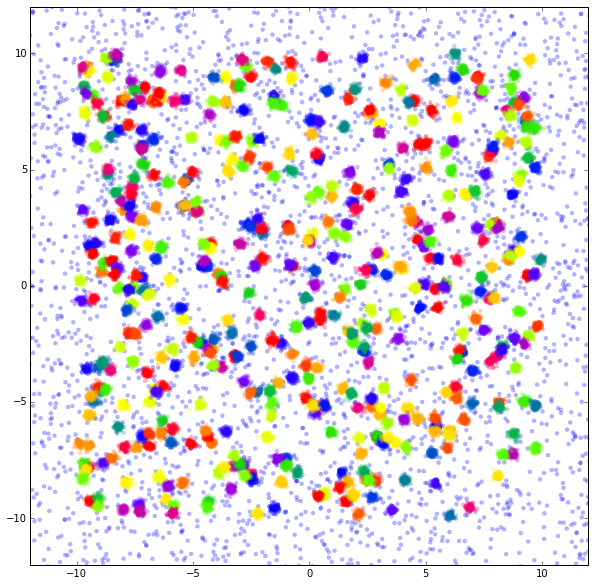

In [15]:
plot_data_with_labels(data, labels)

In [16]:
%%time
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.05, algorithm='kd_tree')
dbscan_labels = dbscan.fit_predict(data)

CPU times: user 2min 25s, sys: 1.4 s, total: 2min 26s
Wall time: 2min 26s


In [17]:
unique_dbscan_labels = np.unique(dbscan_labels)
print(len(unique_dbscan_labels))

355


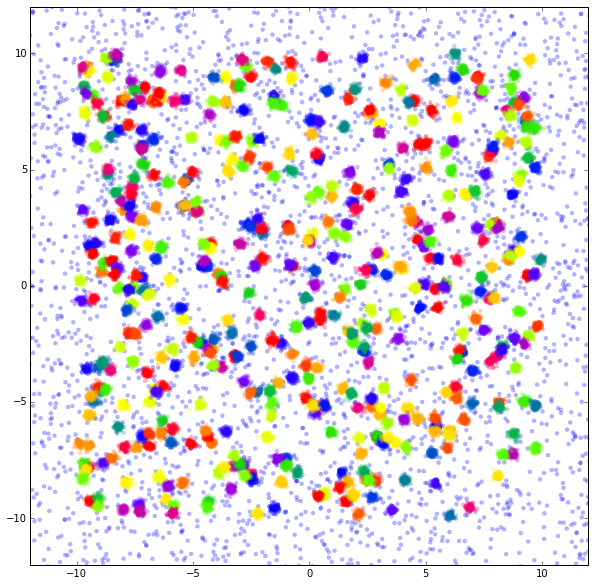

In [18]:
plot_data_with_labels(data, labels)

In [19]:
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score

print("NMI DBSCAN: %0.3f"
      % normalized_mutual_info_score(labels, dbscan_labels))
print("ARI DBSCAN: %0.3f"
      % adjusted_rand_score(labels, dbscan_labels))

NMI DBSCAN: 0.879
ARI DBSCAN: 0.617


In [20]:
%%time
from sklearn.cluster import MiniBatchKMeans

mbkmeans = MiniBatchKMeans(n_clusters=500, init_size=int(1e4), batch_size=int(1e3))
mbkmeans_labels = mbkmeans.fit_predict(data)

CPU times: user 42.3 s, sys: 2.77 s, total: 45.1 s
Wall time: 42 s


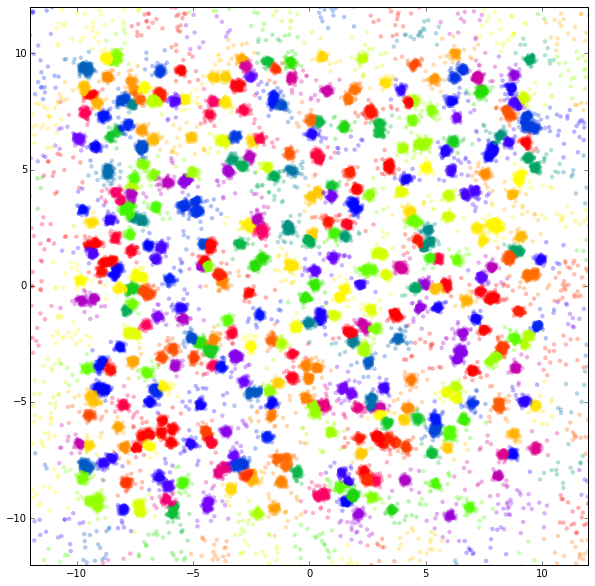

In [21]:
plot_data_with_labels(data, mbkmeans_labels)

In [ ]:
print("NMI MB K-Means: %0.3f"
      % normalized_mutual_info_score(labels, mbkmeans_labels))
print("ARI  MB K-Means: %0.3f"
      % adjusted_rand_score(labels, mbkmeans_labels))

NMI MB K-Means: 0.898
ARI  MB K-Means: 0.248


In [ ]:
%%time
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=500, n_jobs=10)
kmeans_labels = kmeans.fit_predict(data)

In [ ]:
plot_data_with_labels(data, kmeans_labels)

In [ ]:
print("NMI K-Means: %0.3f"
      % normalized_mutual_info_score(labels, kmeans_labels))
print("ARI  K-Means: %0.3f"
      % adjusted_rand_score(labels, kmeans_labels))

In [ ]:
%%time
from sklearn.cluster import Birch

birch = Birch(threshold=0.1, n_clusters=500)
birch_labels = birch.fit_predict(data)

In [ ]:
plot_data_with_labels(data, birch_labels)

In [ ]:
print("NMI Birch: %0.3f"
      % normalized_mutual_info_score(labels, birch_labels))
print("ARI  Birch: %0.3f"
      % adjusted_rand_score(labels, birch_labels))

In [ ]:
%%time
birch.set_params(n_clusters=10)
birch.partial_fit()
birch_labels_small = birch.predict(data)

In [ ]:
plot_data_with_labels(data, birch_labels_small)